# Статистические тесты в контексте EDA #

Описание задания и решение приведены в README-файле по ссыдке:    
[https://github.com/stalkspectrum/sf-ds-course-all/blob/master/03-34-EDA-4/EDA4_Task/README.md](https://github.com/stalkspectrum/sf-ds-course-all/blob/master/03-34-EDA-4/EDA4_Task/README.md)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка и обработка данных ##

In [33]:
main_df = pd.read_csv('salaries.csv')
copy_df = main_df.copy()
display(main_df.head())

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


##### Проверка наличия пустых ячеек по признакам: #####

In [34]:
main_df.isnull().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

#### Проверка наличия дубликатов: ####

In [35]:
main_df[main_df.duplicated()].sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: object

Пустот и дубликатов не обнаружено, теперь можно сразу избавиться от
неинформативных признаков.

1. Первая колонка **`Unnamed: 0`**&nbsp;&mdash; просто порядковый номер.
2. Для анализа полезно иметь &laquo;единую шкалу&raquo; зарплаты, поэтому
оставляем зарплату в долларах **`salary_in_usd`** и удаляем зарплату в
национальных валютах **`salary`**, а также сопутствующий признак
**`salary_currency`**.

In [36]:
main_df.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis='columns', inplace=True)

##### Проверка корректности типов данных #####

In [37]:
display(main_df.info())
print(f'В признаке "work_year" уникальных значений - {main_df.work_year.nunique()}')
print(list(main_df.work_year.unique()))
print(f'В признаке "remote_ratio" уникальных значений - {main_df.remote_ratio.nunique()}')
print(list(main_df.remote_ratio.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary_in_usd       607 non-null    int64 
 5   employee_residence  607 non-null    object
 6   remote_ratio        607 non-null    int64 
 7   company_location    607 non-null    object
 8   company_size        607 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.8+ KB


None

В признаке "work_year" уникальных значений - 3
[2020, 2021, 2022]
В признаке "remote_ratio" уникальных значений - 3
[0, 50, 100]


В числовых признаках **`work_year`** и **`remote_ratio`** только по три уникальных значения, поэтому их можно смело преобразовать в категориальные. Таким образом останется только один числовой непрерывный признак **`salary_in_usd`**.

In [38]:
def set_remote_category(per_cent: int) -> str:
    ''' Преобразует числовой процент удалённой работы в строковую
        категорию no-remote/part-remote/full-remote
    Arguments:
        per_cent [int] -- Доля удалённой работы в процентах
    Returns:
        [str] -- Категория no-remote/part-remote/full-remote
    '''
    if per_cent < 20:
        return 'no-remote'
    elif per_cent > 80:
        return 'full-remote'
    else:
        return 'part-remote'

# Преобразование work_year
main_df.work_year = main_df.work_year.apply(lambda x: str(x))
# Преобразование remote_ratio
main_df.remote_ratio = main_df.remote_ratio.apply(set_remote_category)

In [39]:
main_df.describe(include=['object'])

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,607,607,607,607,607,607,607,607
unique,3,4,4,50,57,3,50,3
top,2022,SE,FT,Data Scientist,US,full-remote,US,M
freq,318,280,588,143,332,381,355,326


Необходимо сократить число категорий в признаках **`job_title`**, **`employee_residence`** и **`company_location`**.

Посмотрим признак **`job_title`**:

In [29]:
main_df.job_title.value_counts()

job_title
Data Scientist                              143
Data Engineer                               132
Data Analyst                                 97
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                  

В признаке **`job_title`** для дальнейшего анализа нас будут интересовать только роли **`Data Scientist`** и **`Data Engineer`**. К тому же они составляют около половины датасета. Остальные роли можно объединить в одну **`Other`**.

In [40]:
main_df.job_title = main_df.job_title.apply(lambda x: x if x in ['Data Scientist',
                                                                 'Data Engineer']
                                                      else 'Other')

Теперь посмотрим признак **`employee_residence`**:

In [31]:
main_df.employee_residence.value_counts()

employee_residence
US    332
GB     44
IN     30
CA     29
DE     25
FR     18
ES     15
GR     13
JP      7
PT      6
BR      6
PK      6
NL      5
PL      4
IT      4
RU      4
AE      3
AT      3
VN      3
TR      3
AU      3
RO      2
BE      2
SG      2
SI      2
DK      2
HU      2
NG      2
MX      2
BO      1
MY      1
TN      1
IE      1
DZ      1
AR      1
CZ      1
JE      1
LU      1
PR      1
RS      1
EE      1
CL      1
HK      1
KE      1
MD      1
CO      1
IR      1
CN      1
MT      1
UA      1
IQ      1
HN      1
BG      1
HR      1
PH      1
NZ      1
CH      1
Name: count, dtype: int64

В признаке **`employee_residence`** больше половины сотрудников работают в США. Поэтому этот признак можно свести к двум категориям: **`US`** и **`Other`**.

In [43]:
main_df.employee_residence = main_df.employee_residence.apply(lambda x: x if x == 'US'
                                                                        else 'Other')

Аналогично смотрим признак **`company_location`**:

In [32]:
main_df.company_location.value_counts()

company_location
US    355
GB     47
CA     30
DE     28
IN     24
FR     15
ES     14
GR     11
JP      6
NL      4
AT      4
PT      4
PL      4
LU      3
PK      3
BR      3
AE      3
MX      3
AU      3
TR      3
DK      3
IT      2
CZ      2
SI      2
RU      2
CH      2
NG      2
CN      2
BE      2
VN      1
EE      1
AS      1
DZ      1
MY      1
MD      1
KE      1
SG      1
CO      1
IR      1
CL      1
MT      1
IL      1
UA      1
IQ      1
RO      1
HR      1
NZ      1
HU      1
HN      1
IE      1
Name: count, dtype: int64

И в признаке **`company_location`** также оставляем только две категории: **`US`** и **`Other`**:

In [44]:
main_df.company_location = main_df.company_location.apply(lambda x: x if x == 'US'
                                                                    else 'Other')

## 2. Разведывательный анализ данных ##

### 2.1. Визуальный анализ данных ###

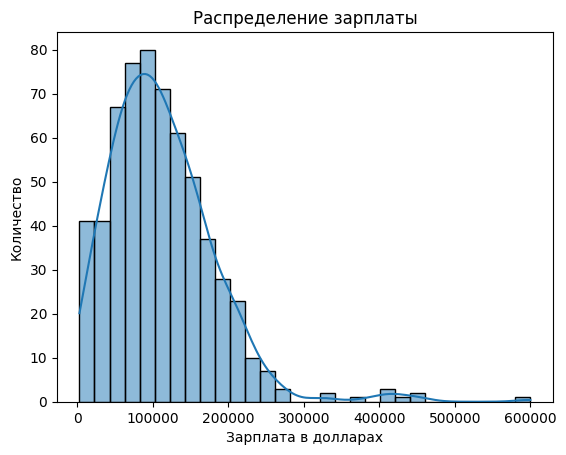

In [44]:
ax = sns.histplot(
    data=main_df['salary_in_usd'],
    bins=30,
    kde=True
)
ax.set(xlabel='Зарплата в долларах', ylabel='Количество')
plt.title('Распределение зарплаты')
plt.show()

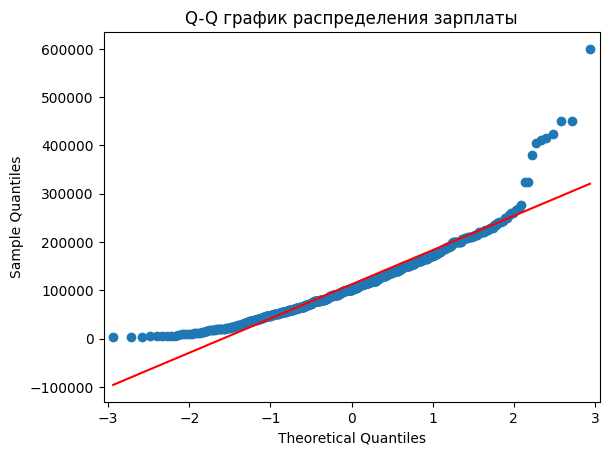

In [46]:
sm.qqplot(main_df['salary_in_usd'], line='s')
plt.title('Q-Q график распределения зарплаты')
plt.show()

### 2.2. Статистический анализ данных ###

## 3. Бизнес-вопросы ##

### 3.1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist? ###

### 3.2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году? ###

### 3.3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров? ###

### 3.4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании? ###

## 4. Дополнительное исследование ##